# Data Preparation
- This notebook is used to visualize and prepare power trace data for our transformer model.

In [2]:
import os
import glob
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

## Find and load the data

In [57]:
def discover_experiment_pairs(data_root_dir: str) -> List[Tuple[str, str]]:
        """
        Finds matching pairs of power CSVs and results CSVs based on
        {MODEL_NAME}_tp{TP}_p{RATE}_d{DATE}.csv and
        results_{MODEL_NAME}_{RATE}_{TP}_final.csv.

        Returns:
            A list of (power_csv_path, results_csv_path).
        """
        all_csvs = glob.glob(
            os.path.join(data_root_dir, "**", "*.csv"), recursive=True
        )
        print(f"Found {len(all_csvs)} CSV files in {data_root_dir}")

        # Separate into "power" files vs "results" files
        power_files = []
        results_files = []

        for csv_path in all_csvs:
            base = os.path.basename(csv_path)
            if base.startswith("results_"):
                results_files.append(csv_path)
            else:
                # Likely a power file if it has _tp and _p in the name
                if "_tp" in base and "_p" in base:
                    power_files.append(csv_path)

        print(f"Found {len(power_files)} power files and {len(results_files)} results files")
     # Attempt to match them by extracting model_name, tp, rate

        def extract_power_info(filename: str):
            # Example:  llama-3-8b_tp2_p2.0_d2025-03-14-07-32-35.csv
            base = os.path.basename(filename)
            model_match = re.match(r"(.*)_tp(\d+)_p([\d\.]+)_d", base)
            print(model_match.groups())
            if not model_match:
                return None
            model_name = model_match.group(1)
            tp = model_match.group(2)
            rate = model_match.group(3)
            return model_name, tp, rate

        def extract_results_info(filename: str):
            # Example: results_Llama-3.1-8B-Instruct_0.5_2_final.csv
            base = os.path.basename(filename)
            result_match = re.match(r"results_(.*)_(\d+\.\d+)_(\d+)_final", base)
            if not result_match:
                return None
            model_name = result_match.group(1)
            rate = result_match.group(2)
            tp = result_match.group(3)
            return model_name, tp, rate

        matched_pairs = []
        for pfile in power_files:
            pinfo = extract_power_info(pfile)
            if not pinfo:
                continue
            p_model, p_tp, p_rate = pinfo

            # Look for a results file that matches
            for rfile in results_files:
                rinfo = extract_results_info(rfile)
                if not rinfo:
                    continue
                r_model, r_tp, r_rate = rinfo

                # Check if they match
                if p_model == r_model and p_tp == r_tp and p_rate == r_rate:
                    matched_pairs.append((pfile, rfile))
                    break  # Found our match, no need to look further

        print(
            f"Found {len(power_files)} power files, {len(results_files)} results files, "
            f"matched {len(matched_pairs)} pairs."
        )
        return matched_pairs

def parse_results_csv(csv_path: str) -> pd.DataFrame:
        """
        Parse the results CSV (e.g. results_{MODEL_NAME}_{RATE}_{TP}_final.csv).

        Expects columns:
        [Request Time, Model, Data Source, Poisson Arrival Rate, Tensor Parallel Size,
         Input Tokens, Output Tokens, E2E Latency]

        Returns:
            Pandas DataFrame with a 'request_time' column (datetime64).
        """
        try:
            df = pd.read_csv(csv_path)
            if "Request Time" in df.columns:
                # Convert to datetime (the example data uses numeric timestamps in seconds)
                if pd.api.types.is_numeric_dtype(df["Request Time"]):
                    df["request_time"] = pd.to_datetime(df["Request Time"], unit="s")
                else:
                    df["request_time"] = pd.to_datetime(df["Request Time"])
            else:
                # Fallback if column not found
                df["request_time"] = pd.date_range(
                    start=pd.Timestamp.now(), periods=len(df), freq="s"
                )
            return df
        except Exception as e:
            print(f"Error reading results file {csv_path}: {e}")
            return pd.DataFrame()

def parse_power_csv(csv_path: str) -> pd.DataFrame:
    """
    Parse the GPU power trace CSV and sum up the first X power values of each group of 8 rows,
    where X is the tensor parallelism extracted from the filename (_tpX).
    The timestamp for each sample is taken as the minimum timestamp within the group.
    
    Expects columns (for each GPU row):
        timestamp, power.draw [W], utilization.gpu [%], memory.used [MiB]
    """
    try:
        # Read CSV and clean up column names
        df = pd.read_csv(csv_path, skipinitialspace=True)
        df.columns = [col.strip().lower() for col in df.columns]

        # Rename power and memory columns if needed
        if "power.draw [w]" in df.columns:
            df.rename(columns={"power.draw [w]": "power"}, inplace=True)
            df.rename(columns={"memory.used [mib]": "memory"}, inplace=True)

        # Clean up the power column (remove non-numeric characters and convert to numeric)
        if df["power"].dtype == object:
            df["power"] = df["power"].replace(r"[^\d.]", "", regex=True)
            df["power"] = pd.to_numeric(df["power"])

        # Clean up the memory column if present
        if "memory" in df.columns and df["memory"].dtype == object:
            df["memory"] = df["memory"].replace(r"[^\d.]", "", regex=True)
            df["memory"] = pd.to_numeric(df["memory"])

        # Identify the timestamp column (any column containing "time")
        time_col = None
        for c in df.columns:
            if "time" in c:
                time_col = c
                break
        if not time_col:
            raise ValueError("No timestamp column found in power CSV")

        # Convert timestamps to datetime and rename column to "timestamp"
        df[time_col] = pd.to_datetime(df[time_col])
        df.rename(columns={time_col: "timestamp"}, inplace=True)

        # Extract tensor parallelism from the filename (_tpX -> X)
        tp_match = re.search(r'_tp(\d+)', csv_path)
        tensor_parallelism = int(tp_match.group(1)) if tp_match else 1
        print(f"Extracted tensor parallelism {tensor_parallelism} from {csv_path}")

        num_rows = len(df)
        num_complete_groups = num_rows // 8
        df = df.iloc[:num_complete_groups * 8]
        groups = df.groupby(np.arange(len(df)) // 8)

        result = groups.apply(lambda x: pd.Series({
            "timestamp": x["timestamp"].min(),
            "power": x.iloc[:tensor_parallelism]["power"].sum()
        })).reset_index(drop=True)

        return result

    except Exception as e:
        print(f"Error reading power file {csv_path}: {e}")
        return pd.DataFrame()
    
def plot_power_val(df: pd.DataFrame, title: str, ylabel: str, xlabel: str, save_path: Optional[str] = None):
    plt.figure(figsize=(12, 6))
    plt.plot(df["timestamp"], df["power"], label="Power")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # plt.yscale("log")
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()


Found 144 CSV files in ../client/
Found 50 power files and 94 results files
('llama-3-8b', '2', '2.0')
('llama-3-8b', '1', '1.0')
('llama-3-8b', '8', '4.0')
('llama-3-8b', '4', '1.0')
('llama-3-8b', '8', '0.125')
('llama-3-8b', '2', '0.5')
('llama-3-8b', '1', '0.5')
('llama-3-8b', '8', '0.5')
('llama-3-8b', '2', '1.0')
('llama-3-8b', '4', '2.0')
('llama-3-8b', '2', '1.0')
('llama-3-8b', '1', '0.25')
('llama-3-8b', '2', '0.125')
('llama-3-8b', '2', '2.0')
('llama-3-8b', '8', '1.0')
('llama-3-8b', '2', '4.0')
('llama-3-8b', '2', '4.0')
('llama-3-8b', '8', '0.25')
('llama-3-8b', '4', '0.125')
('llama-3-8b', '4', '0.25')
('llama-3-8b', '1', '0.125')
('llama-3-8b', '1', '2.0')
('llama-3-8b', '2', '0.25')
('llama-3-8b', '4', '4.0')
('llama-3-8b', '8', '2.0')
('llama-3-8b', '4', '0.5')
('deepseek-r1-distill-8b', '8', '0.125')
('deepseek-r1-distill-8b', '2', '0.125')
('deepseek-r1-distill-8b', '1', '0.5')
('deepseek-r1-distill-8b', '2', '0.25')
('deepseek-r1-distill-8b', '8', '2.0')
('deepseek

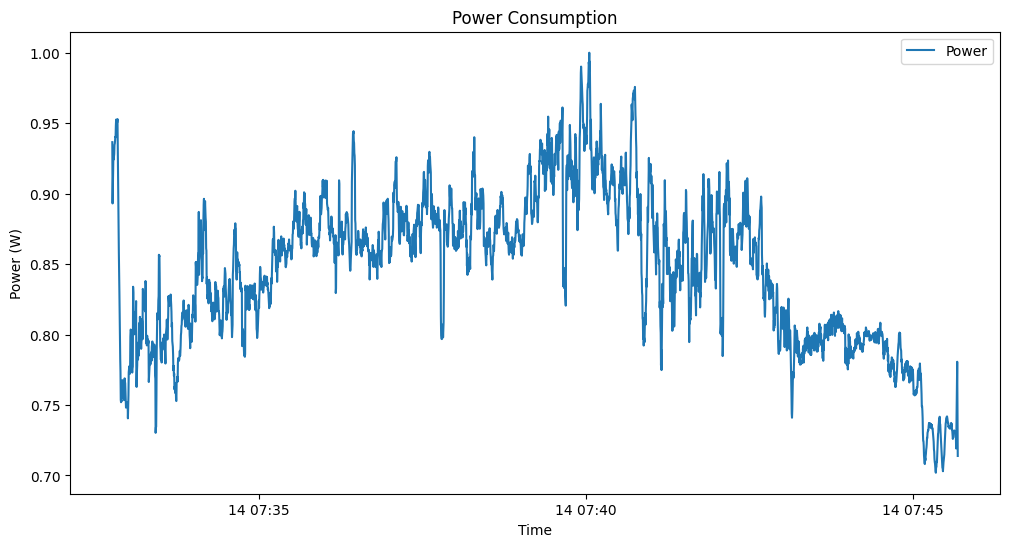

Processing ../client/llama-3-8b/llama-3-8b_tp1_p1.0_d2025-03-13-18-38-32.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_1_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p1.0_d2025-03-13-18-38-32.csv
6456
5391


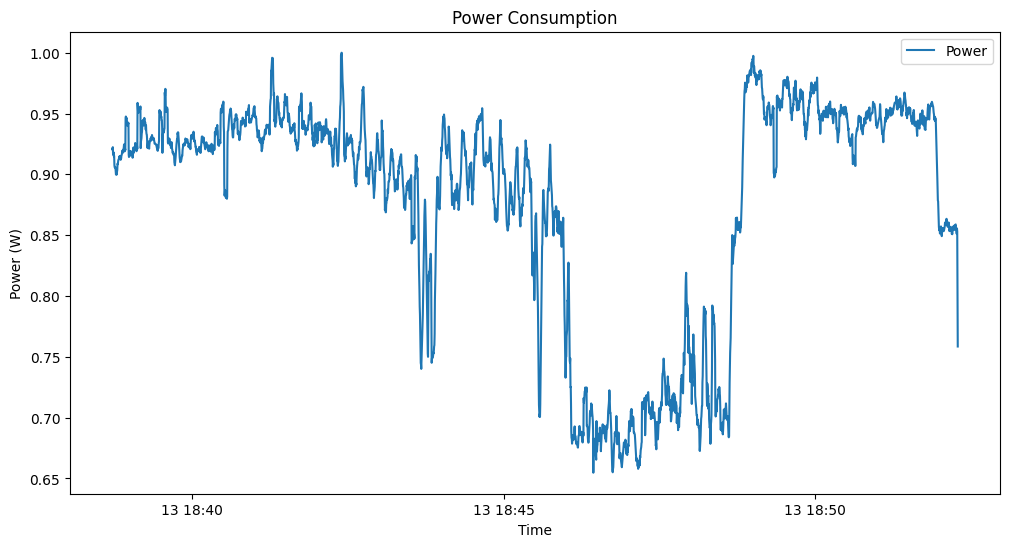

Processing ../client/llama-3-8b/llama-3-8b_tp8_p4.0_d2025-03-14-01-22-15.csv and ../client/llama-3-8b/results_llama-3-8b_4.0_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p4.0_d2025-03-14-01-22-15.csv
6254
11106


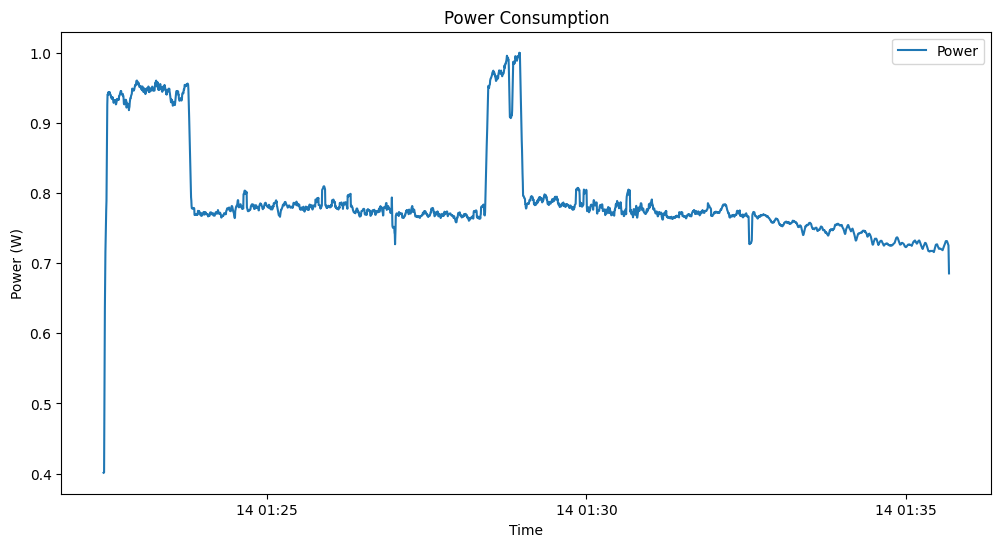

Processing ../client/llama-3-8b/llama-3-8b_tp4_p1.0_d2025-03-13-22-02-25.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_4_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p1.0_d2025-03-13-22-02-25.csv
6384
5112


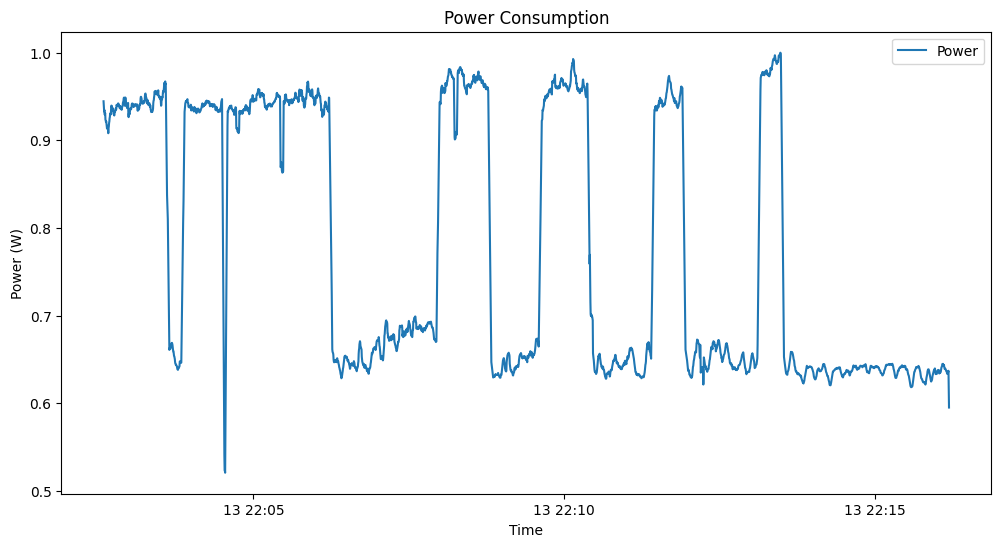

Processing ../client/llama-3-8b/llama-3-8b_tp8_p0.125_d2025-03-14-00-21-11.csv and ../client/llama-3-8b/results_llama-3-8b_0.125_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p0.125_d2025-03-14-00-21-11.csv
4726
729


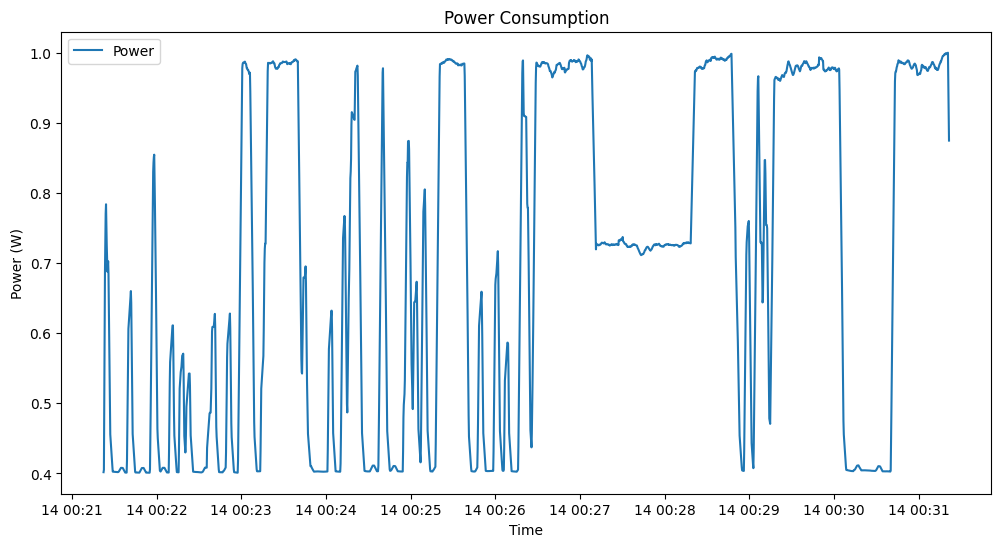

Processing ../client/llama-3-8b/llama-3-8b_tp2_p0.5_d2025-03-13-20-25-44.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p0.5_d2025-03-13-20-25-44.csv


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_43639/2706641532.py:147: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col])


5482
2547


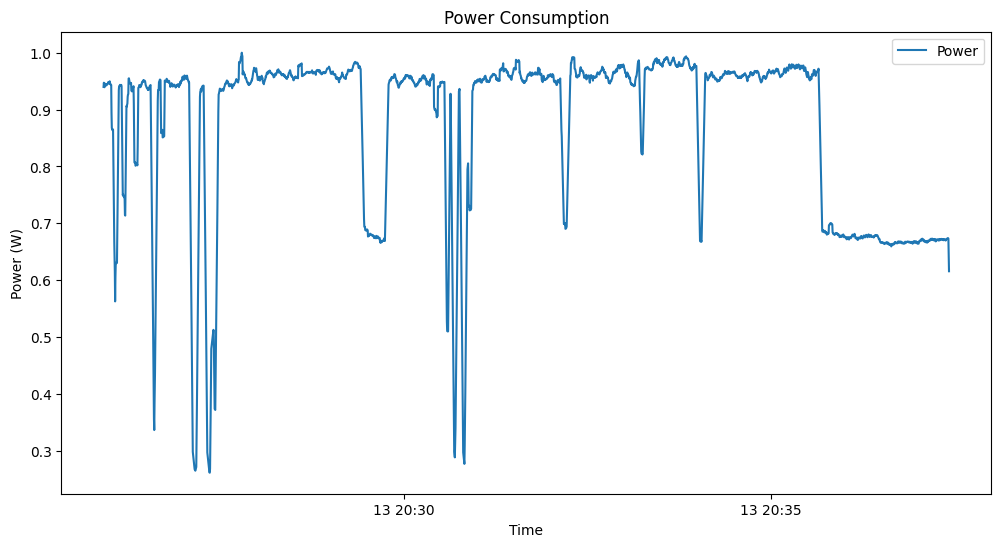

Processing ../client/llama-3-8b/llama-3-8b_tp1_p0.5_d2025-03-13-18-28-09.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_1_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p0.5_d2025-03-13-18-28-09.csv
4860
2691


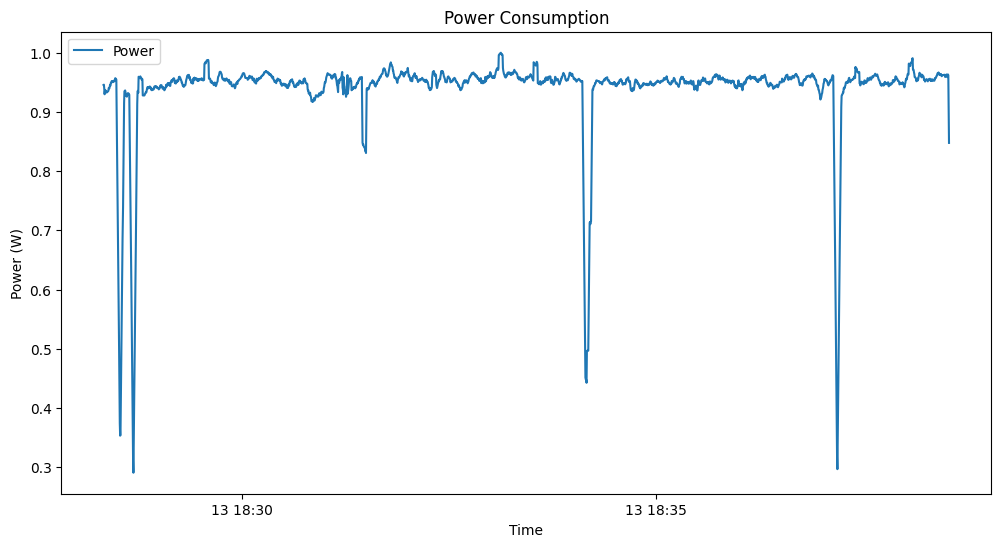

Processing ../client/llama-3-8b/llama-3-8b_tp8_p0.5_d2025-03-14-00-42-29.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p0.5_d2025-03-14-00-42-29.csv
4872
2457


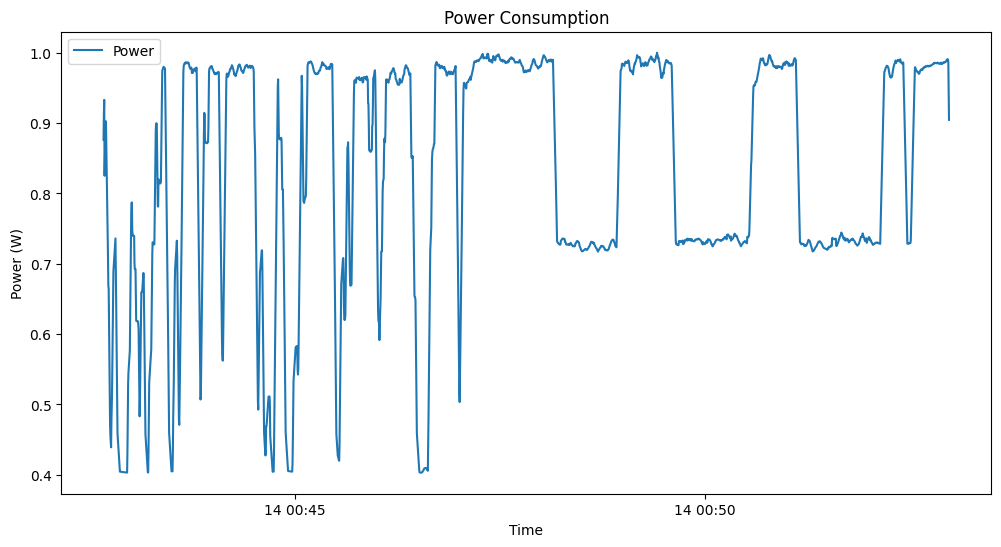

Processing ../client/llama-3-8b/llama-3-8b_tp2_p1.0_d2025-03-14-07-17-23.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p1.0_d2025-03-14-07-17-23.csv
5280
5220


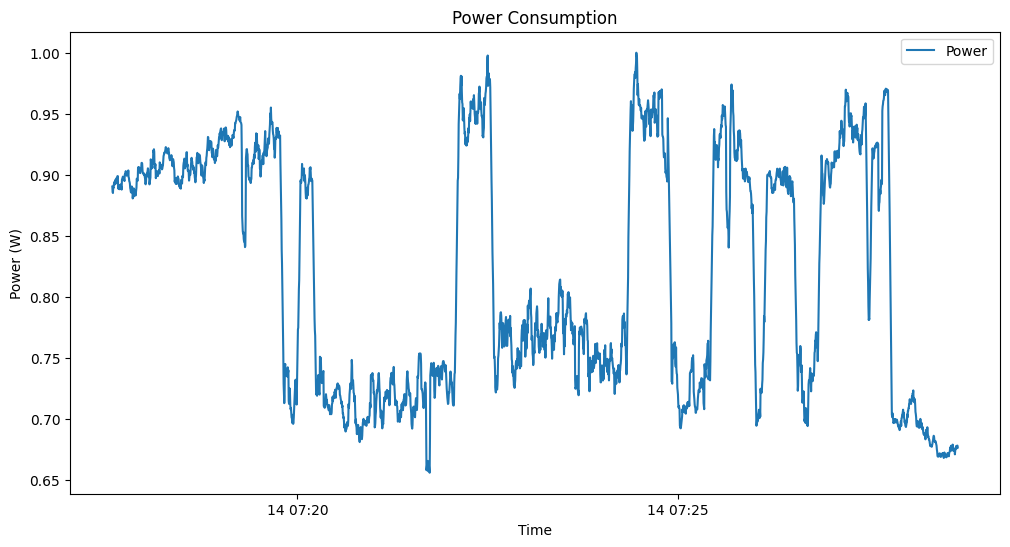

Processing ../client/llama-3-8b/llama-3-8b_tp4_p2.0_d2025-03-13-22-16-11.csv and ../client/llama-3-8b/results_llama-3-8b_2.0_4_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p2.0_d2025-03-13-22-16-11.csv
6930
9675


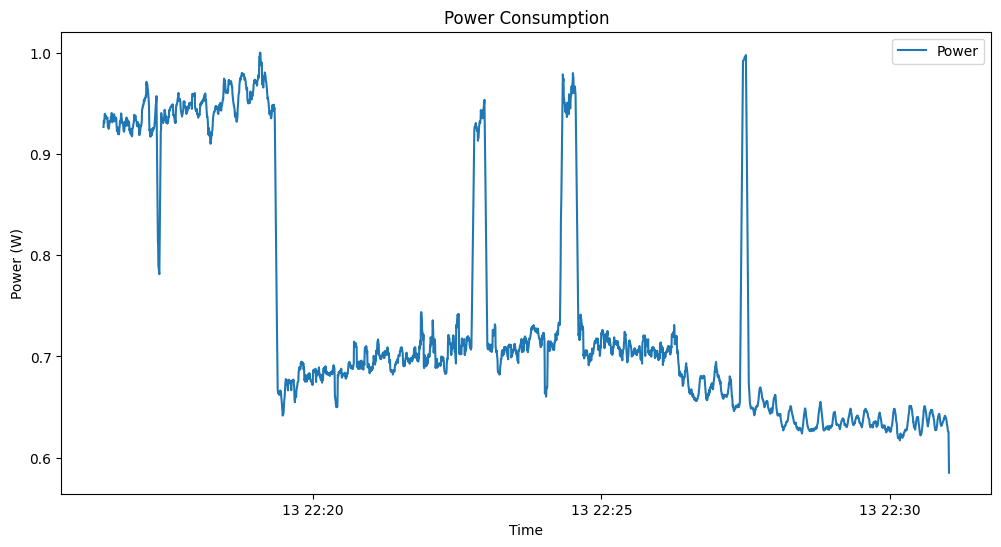

Processing ../client/llama-3-8b/llama-3-8b_tp2_p1.0_d2025-03-14-07-17-20.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p1.0_d2025-03-14-07-17-20.csv
7154
5220


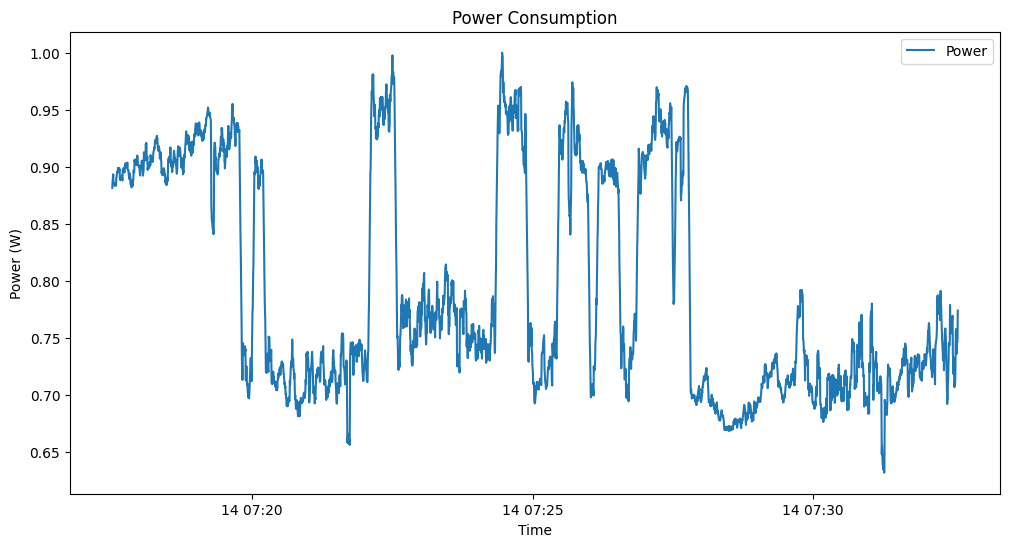

Processing ../client/llama-3-8b/llama-3-8b_tp1_p0.25_d2025-03-13-18-17-39.csv and ../client/llama-3-8b/results_llama-3-8b_0.25_1_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p0.25_d2025-03-13-18-17-39.csv
4894
1170


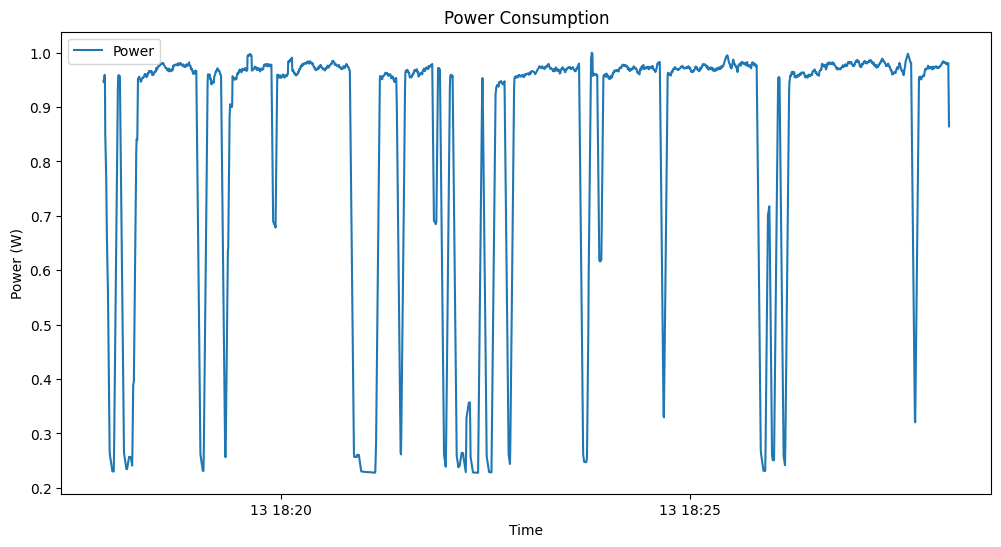

Processing ../client/llama-3-8b/llama-3-8b_tp2_p0.125_d2025-03-13-20-04-49.csv and ../client/llama-3-8b/results_llama-3-8b_0.125_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p0.125_d2025-03-13-20-04-49.csv
4696
729


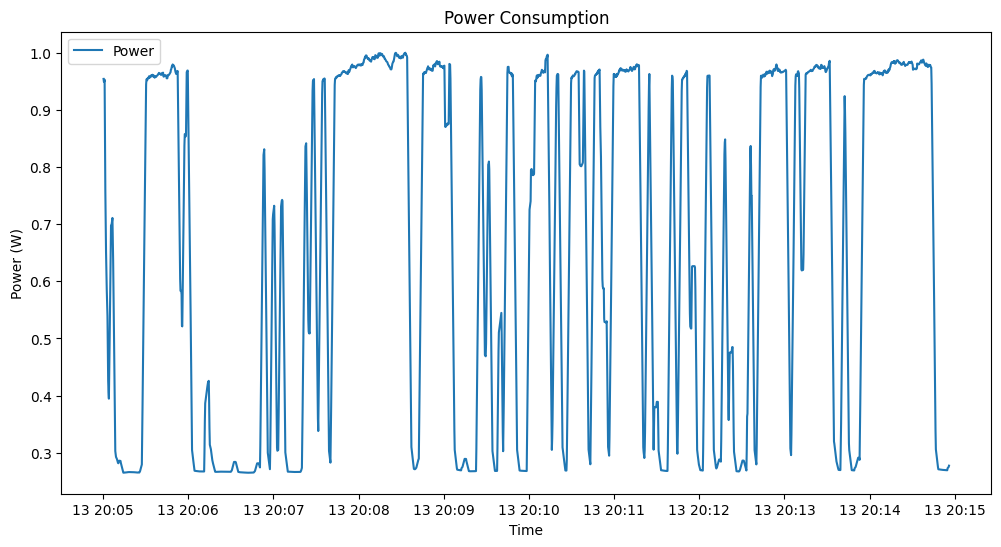

Processing ../client/llama-3-8b/llama-3-8b_tp2_p2.0_d2025-03-14-07-28-41.csv and ../client/llama-3-8b/results_llama-3-8b_2.0_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p2.0_d2025-03-14-07-28-41.csv
7988
7245


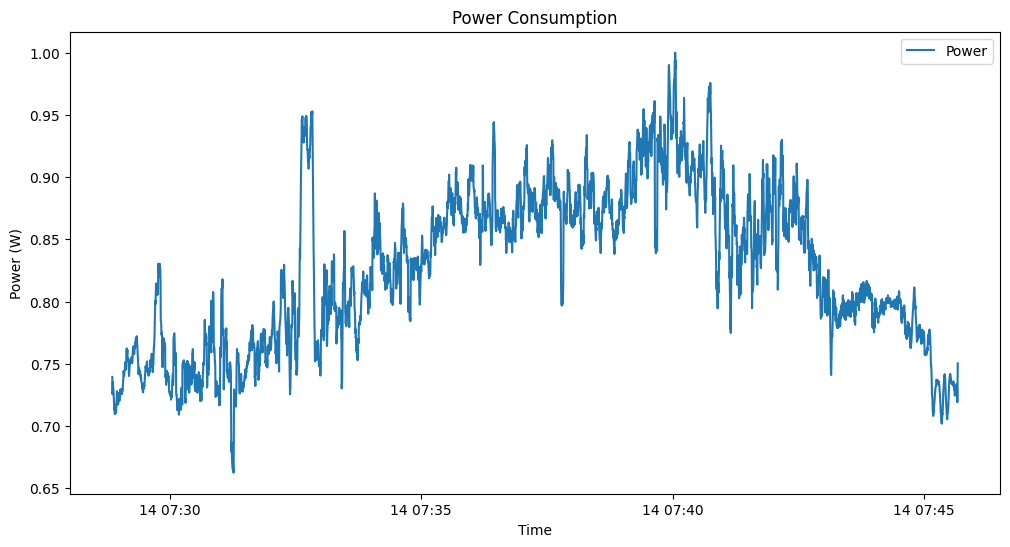

Processing ../client/llama-3-8b/llama-3-8b_tp8_p1.0_d2025-03-14-00-52-58.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p1.0_d2025-03-14-00-52-58.csv
6536
4995


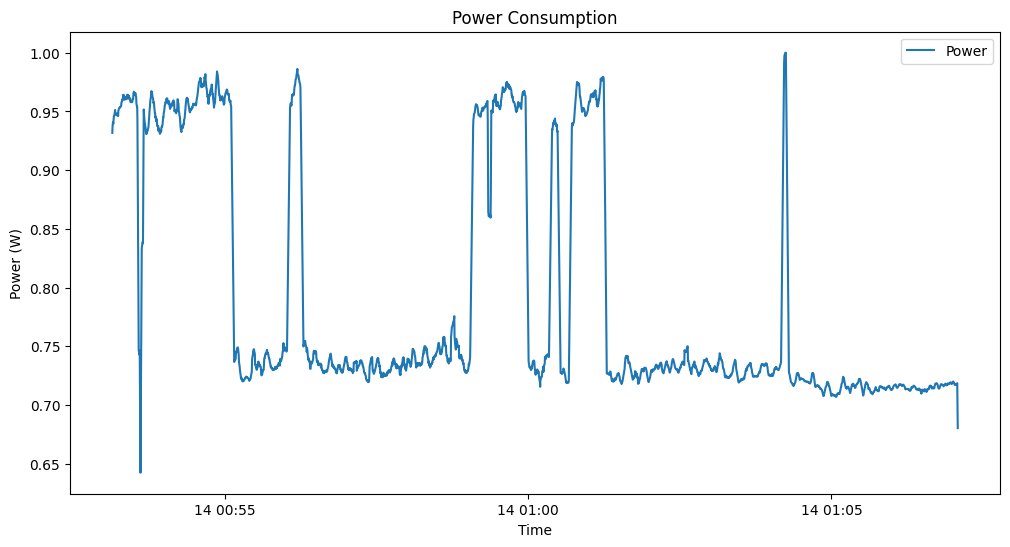

Processing ../client/llama-3-8b/llama-3-8b_tp2_p4.0_d2025-03-14-07-45-41.csv and ../client/llama-3-8b/results_llama-3-8b_4.0_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p4.0_d2025-03-14-07-45-41.csv
6858
9252


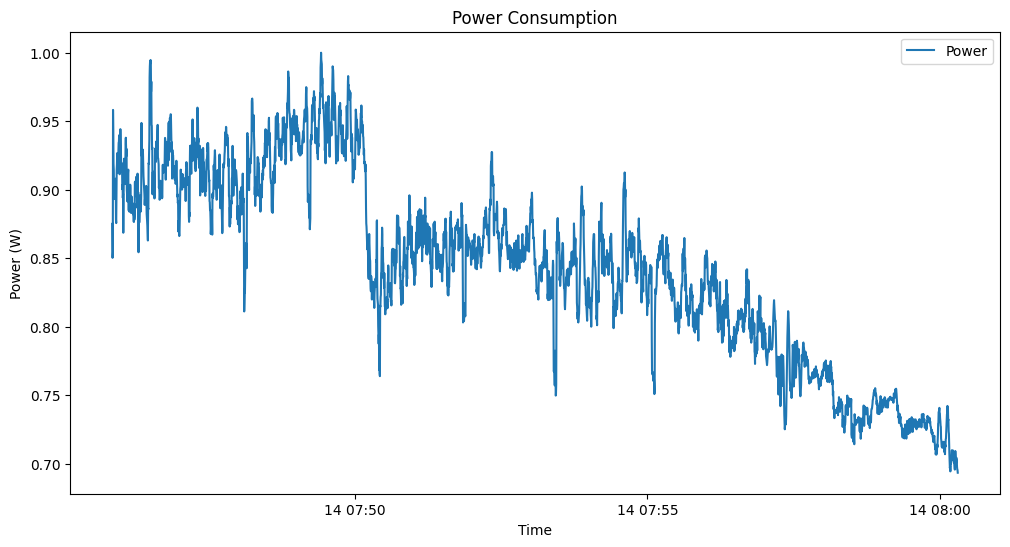

Processing ../client/llama-3-8b/llama-3-8b_tp2_p4.0_d2025-03-14-07-45-40.csv and ../client/llama-3-8b/results_llama-3-8b_4.0_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p4.0_d2025-03-14-07-45-40.csv
6852
9252


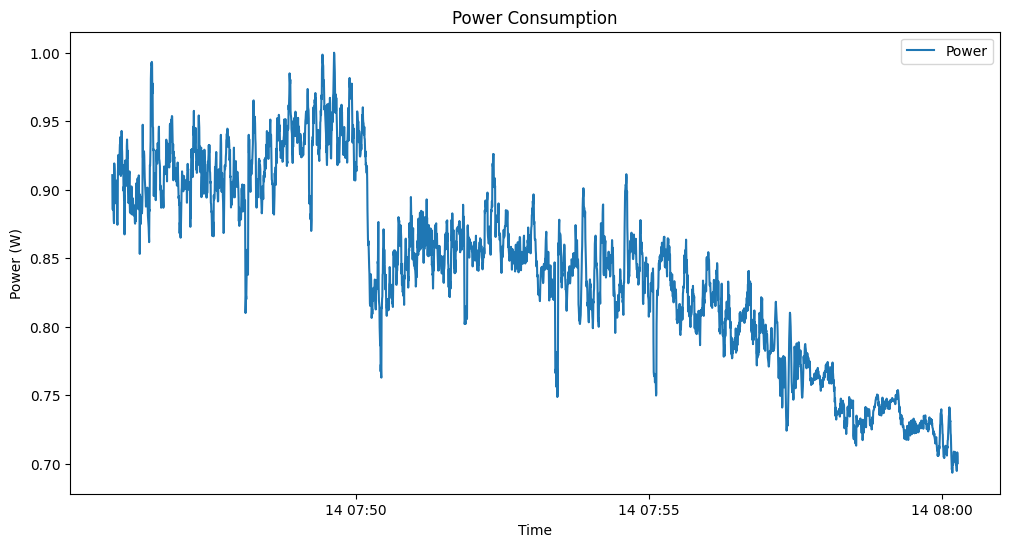

Processing ../client/llama-3-8b/llama-3-8b_tp8_p0.25_d2025-03-14-00-31-21.csv and ../client/llama-3-8b/results_llama-3-8b_0.25_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p0.25_d2025-03-14-00-31-21.csv
5174
1170


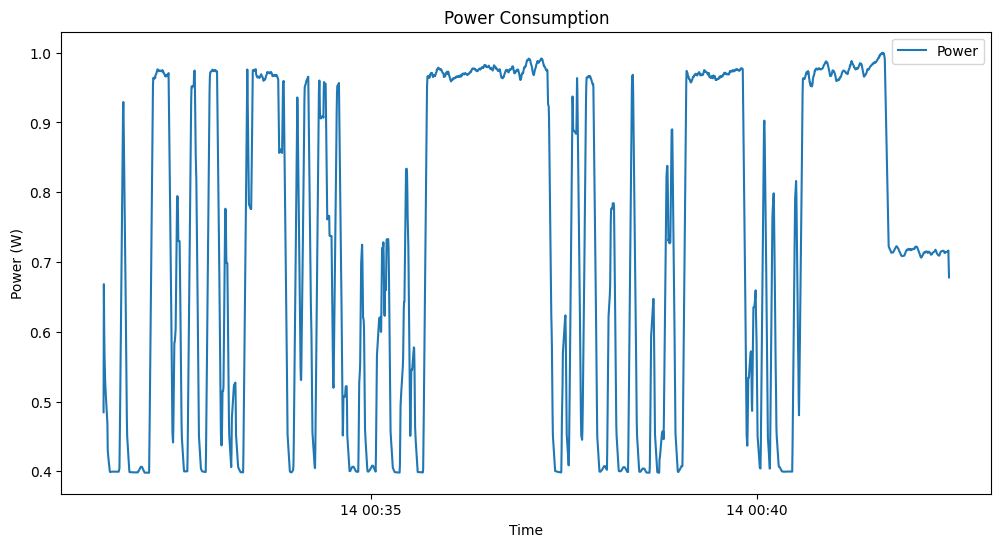

Processing ../client/llama-3-8b/llama-3-8b_tp4_p0.125_d2025-03-13-21-31-40.csv and ../client/llama-3-8b/results_llama-3-8b_0.125_4_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p0.125_d2025-03-13-21-31-40.csv
4672
702


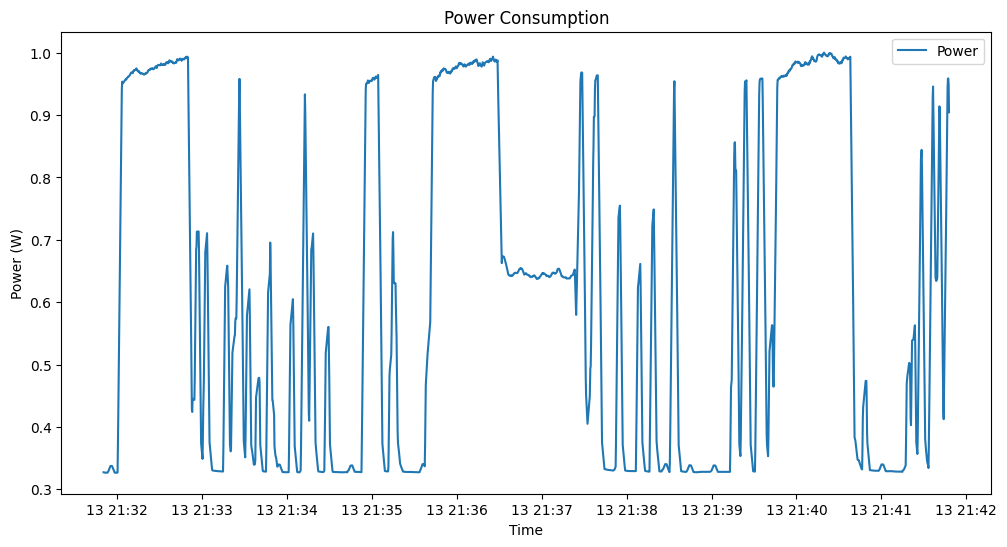

Processing ../client/llama-3-8b/llama-3-8b_tp4_p0.25_d2025-03-13-21-41-48.csv and ../client/llama-3-8b/results_llama-3-8b_0.25_4_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p0.25_d2025-03-13-21-41-48.csv
4736
1305


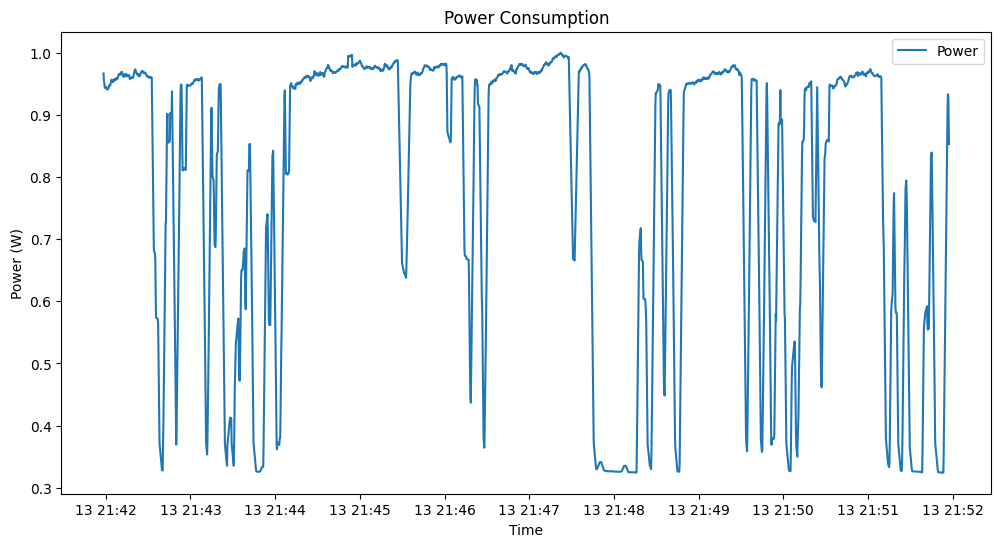

Processing ../client/llama-3-8b/llama-3-8b_tp1_p0.125_d2025-03-13-18-07-08.csv and ../client/llama-3-8b/results_llama-3-8b_0.125_1_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p0.125_d2025-03-13-18-07-08.csv
4906
639


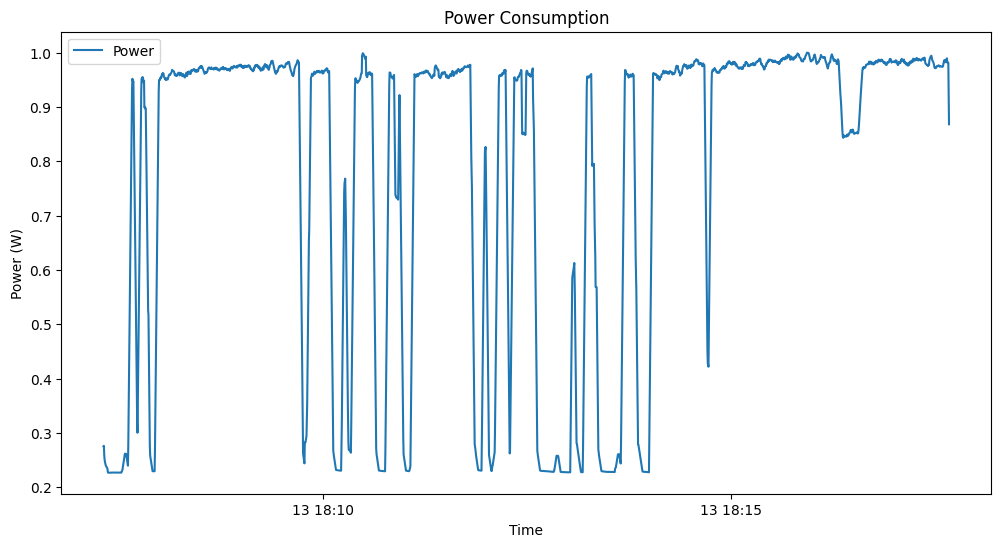

Processing ../client/llama-3-8b/llama-3-8b_tp1_p2.0_d2025-03-13-18-52-17.csv and ../client/llama-3-8b/results_llama-3-8b_2.0_1_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p2.0_d2025-03-13-18-52-17.csv
5786
7947


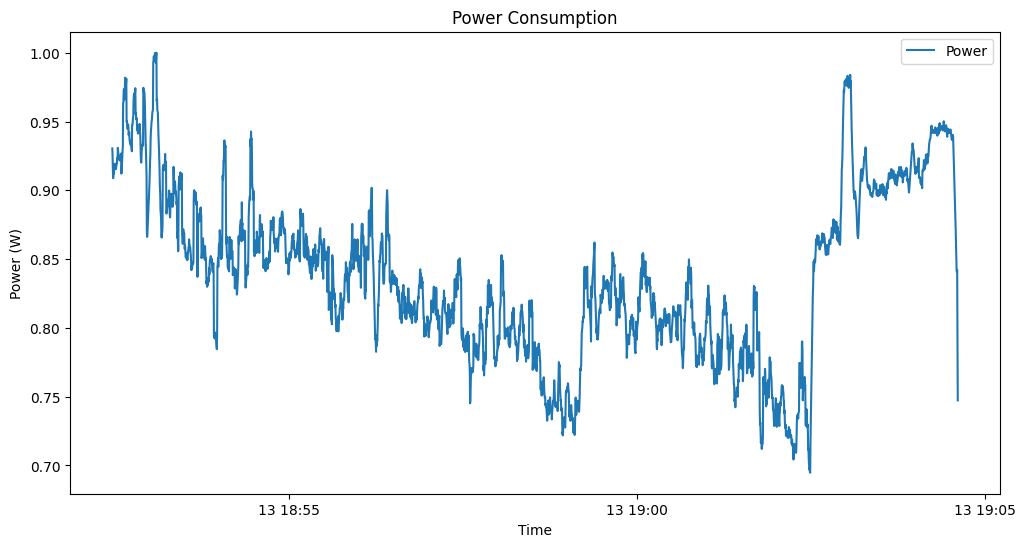

Processing ../client/llama-3-8b/llama-3-8b_tp2_p0.25_d2025-03-13-20-14-56.csv and ../client/llama-3-8b/results_llama-3-8b_0.25_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p0.25_d2025-03-13-20-14-56.csv
5042
1305


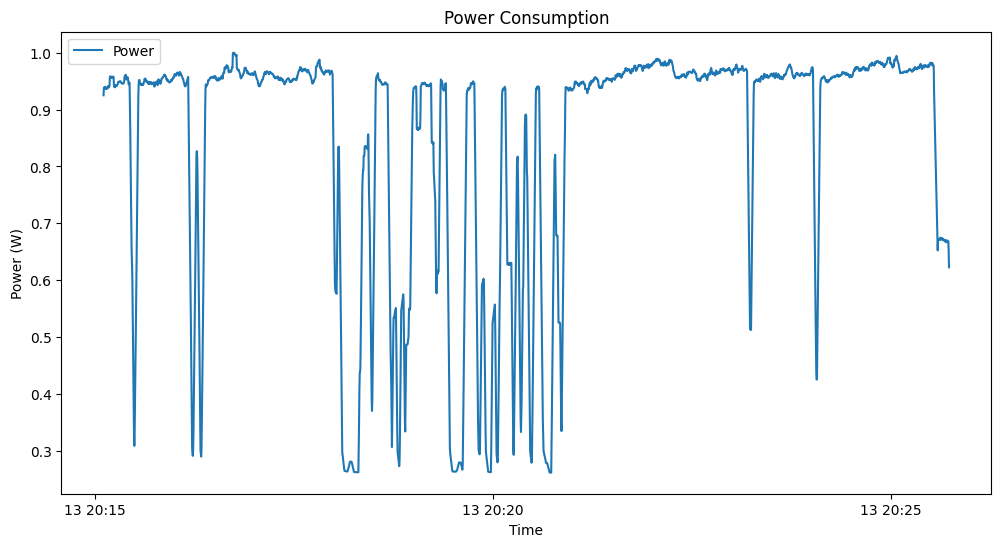

Processing ../client/llama-3-8b/llama-3-8b_tp4_p4.0_d2025-03-13-22-31-01.csv and ../client/llama-3-8b/results_llama-3-8b_4.0_4_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p4.0_d2025-03-13-22-31-01.csv
5872
10161


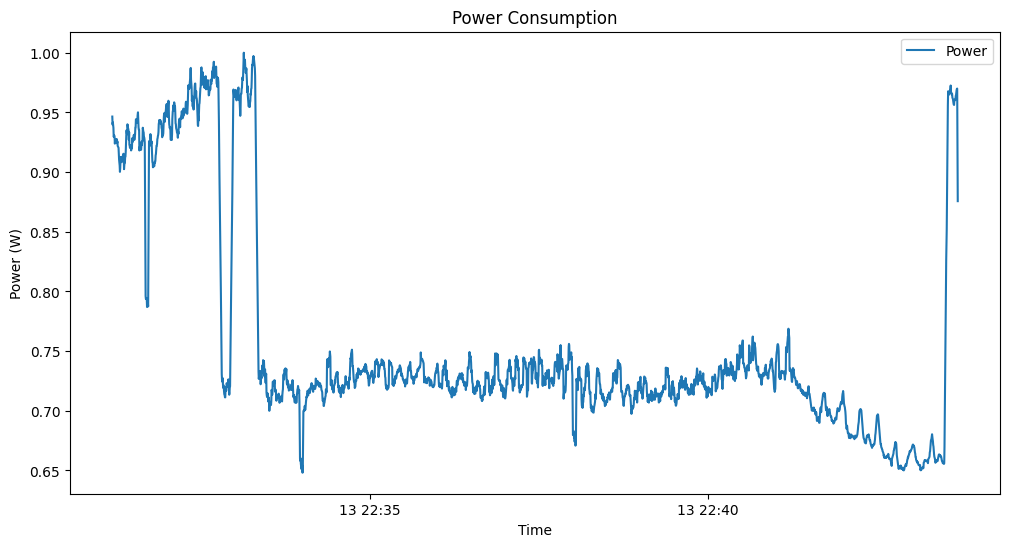

Processing ../client/llama-3-8b/llama-3-8b_tp8_p2.0_d2025-03-14-01-07-05.csv and ../client/llama-3-8b/results_llama-3-8b_2.0_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p2.0_d2025-03-14-01-07-05.csv
7112
9837


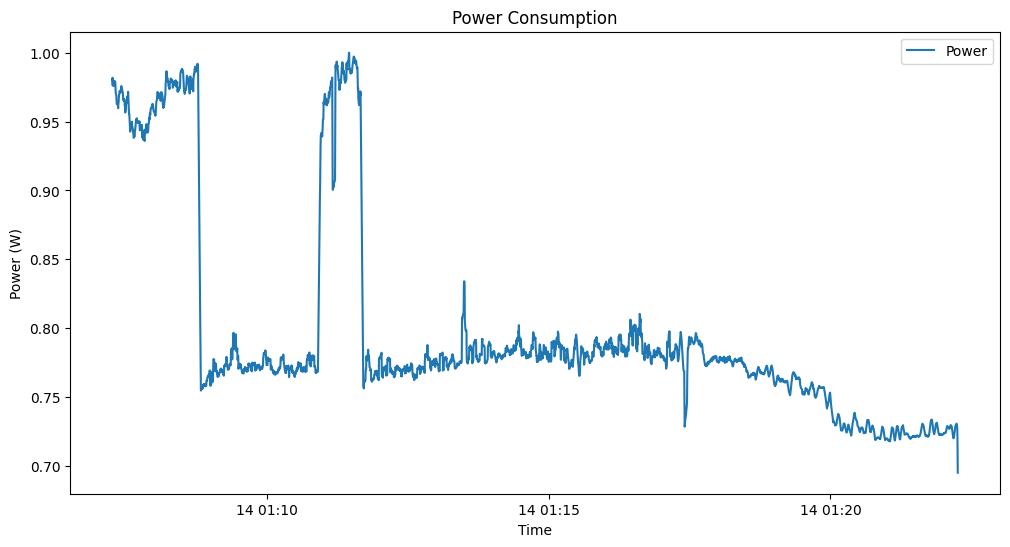

Processing ../client/llama-3-8b/llama-3-8b_tp4_p0.5_d2025-03-13-21-51-57.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_4_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p0.5_d2025-03-13-21-51-57.csv
4852
2817


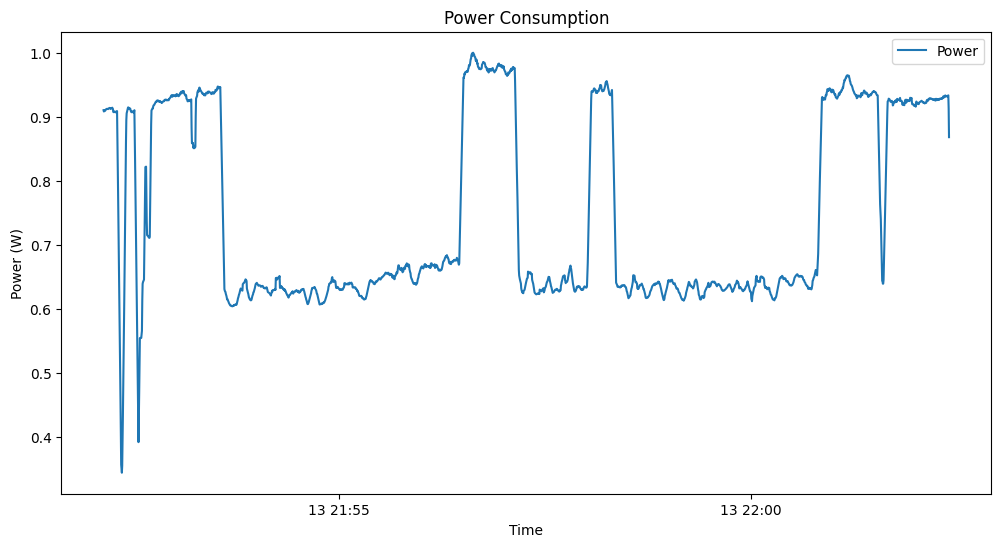

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p0.125_d2025-03-14-19-44-48.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.125_8_final.csv
Extracted tensor parallelism 8 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p0.125_d2025-03-14-19-44-48.csv
5144
648


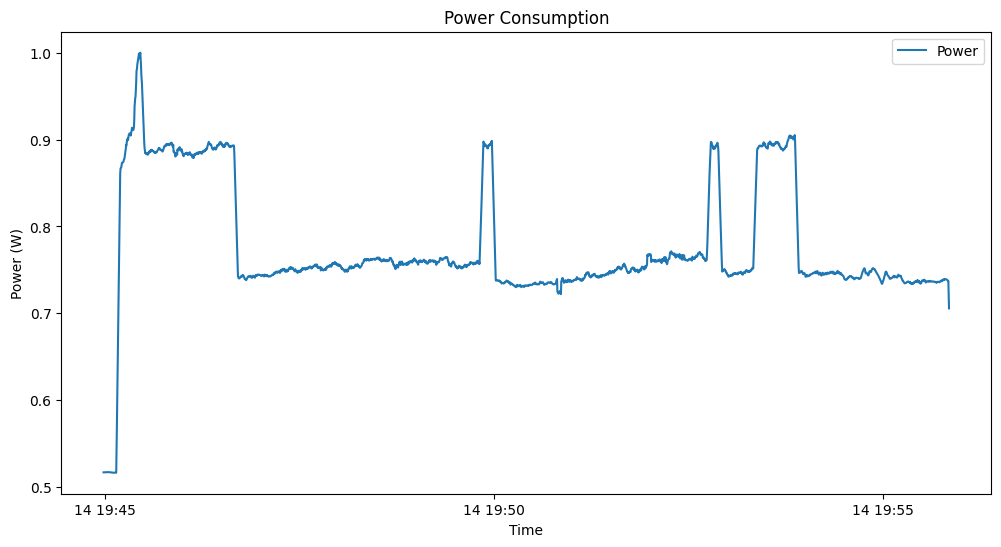

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp2_p0.125_d2025-03-14-16-49-20.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.125_2_final.csv
Extracted tensor parallelism 2 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp2_p0.125_d2025-03-14-16-49-20.csv
6102
486


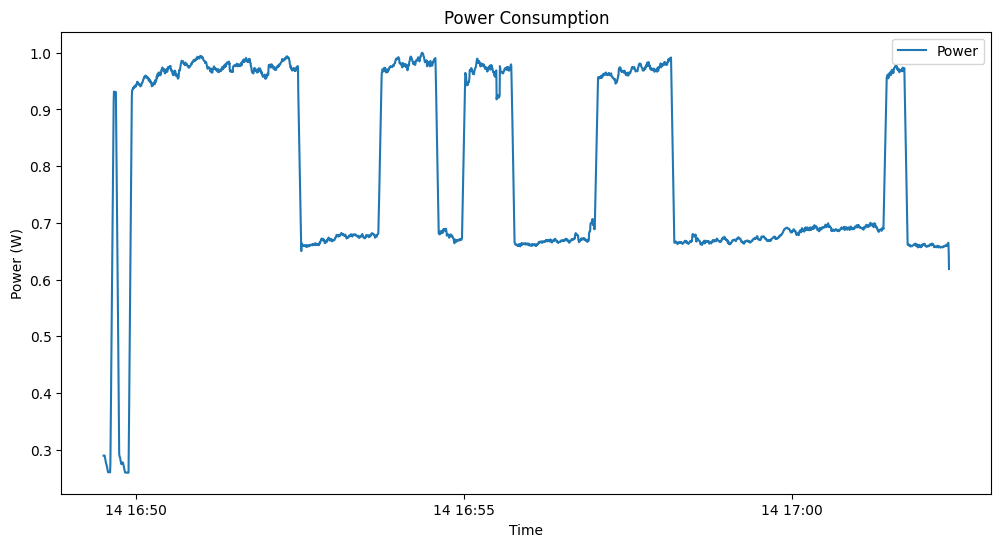

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p0.5_d2025-03-14-08-46-38.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.5_1_final.csv
Extracted tensor parallelism 1 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p0.5_d2025-03-14-08-46-38.csv
6682
1944


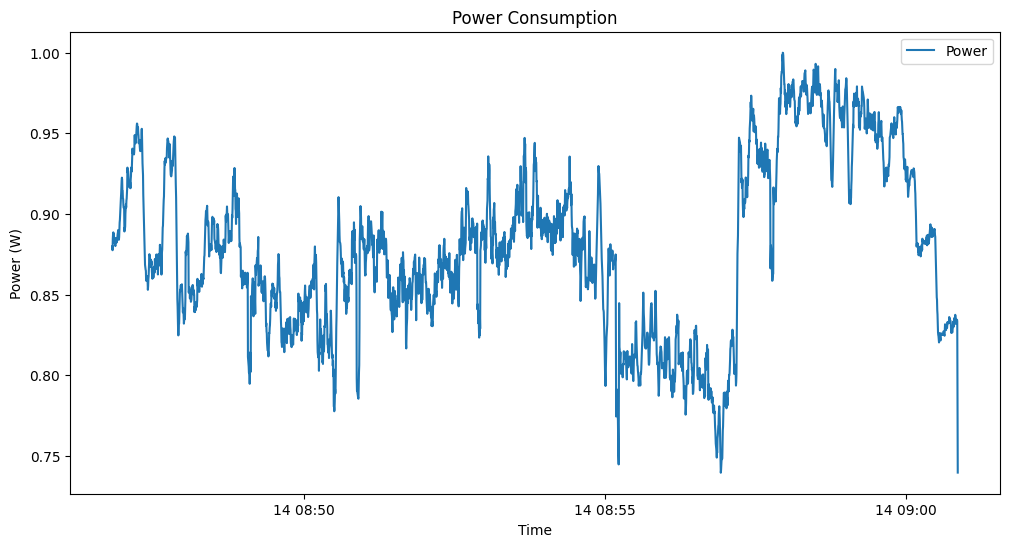

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp2_p0.25_d2025-03-14-17-02-23.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.25_2_final.csv
Extracted tensor parallelism 2 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp2_p0.25_d2025-03-14-17-02-23.csv
5812
1350


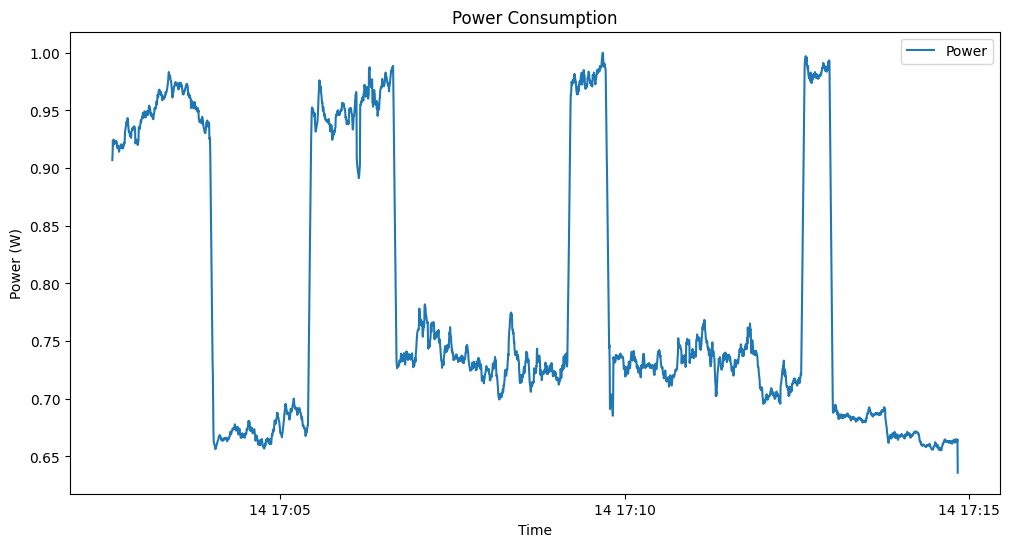

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p2.0_d2025-03-14-20-40-28.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_2.0_8_final.csv
Extracted tensor parallelism 8 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p2.0_d2025-03-14-20-40-28.csv
6676
2430


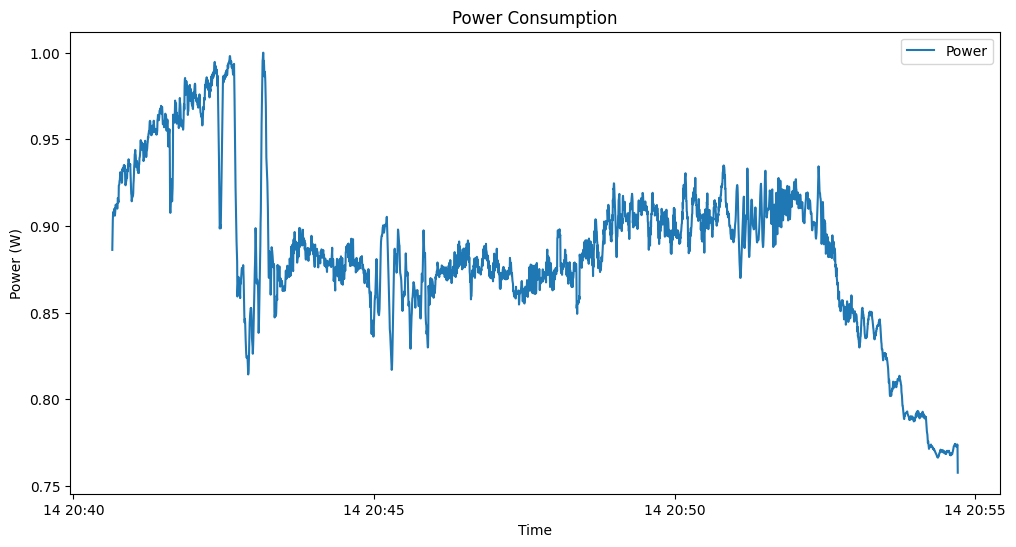

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp2_p2.0_d2025-03-14-17-45-22.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_2.0_2_final.csv
Extracted tensor parallelism 2 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp2_p2.0_d2025-03-14-17-45-22.csv
8008
2349


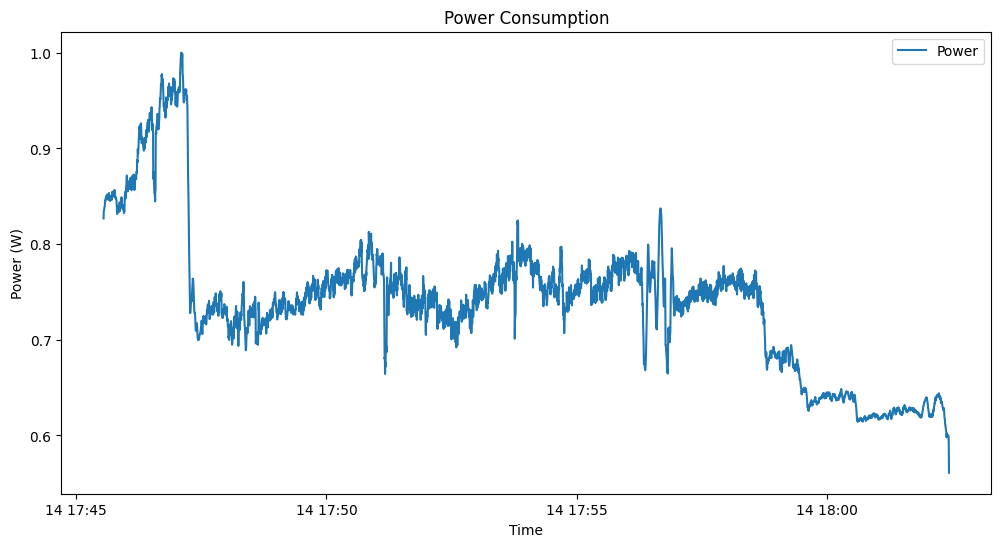

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p0.5_d2025-03-14-20-09-47.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.5_8_final.csv
Extracted tensor parallelism 8 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p0.5_d2025-03-14-20-09-47.csv
6898
2187


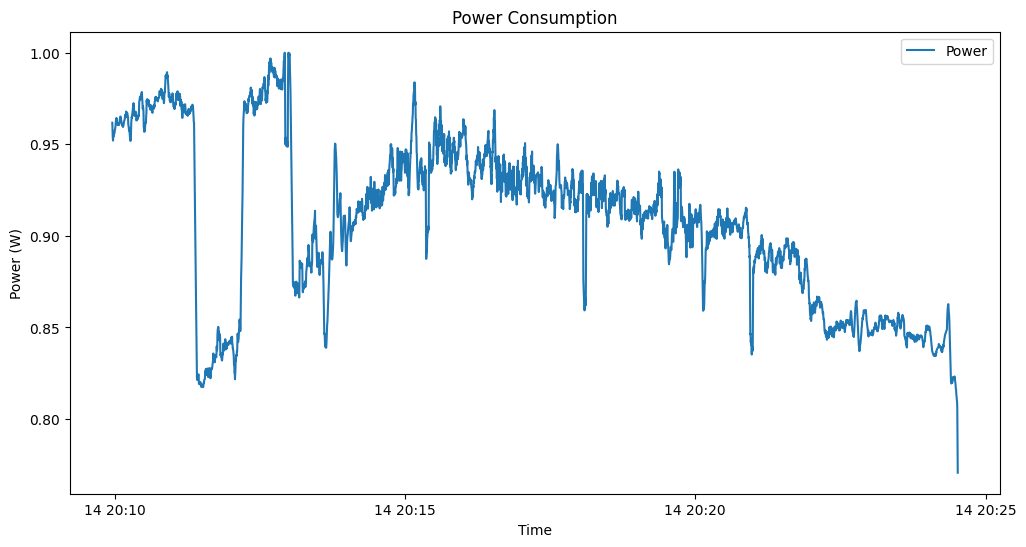

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p2.0_d2025-03-14-09-17-30.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_2.0_1_final.csv
Extracted tensor parallelism 1 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p2.0_d2025-03-14-09-17-30.csv
7730
1800


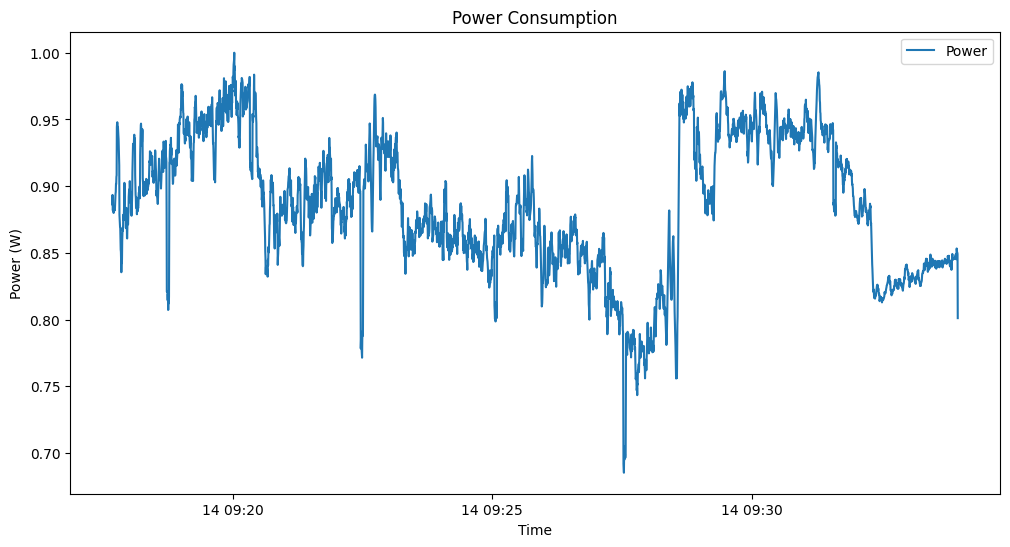

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p0.125_d2025-03-14-08-21-49.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.125_1_final.csv
Extracted tensor parallelism 1 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p0.125_d2025-03-14-08-21-49.csv
5232
792


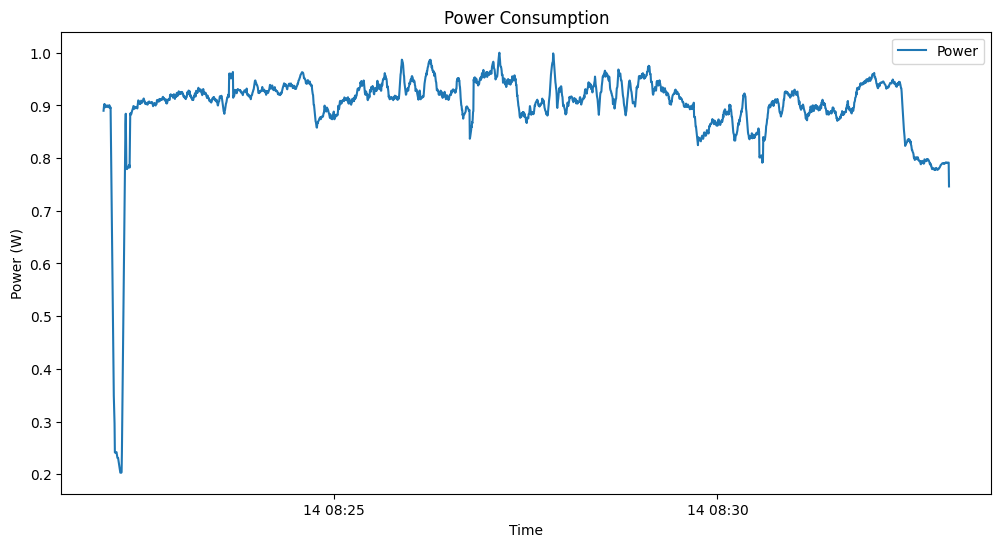

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp4_p0.125_d2025-03-14-18-17-31.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.125_4_final.csv
Extracted tensor parallelism 4 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp4_p0.125_d2025-03-14-18-17-31.csv
6362
513


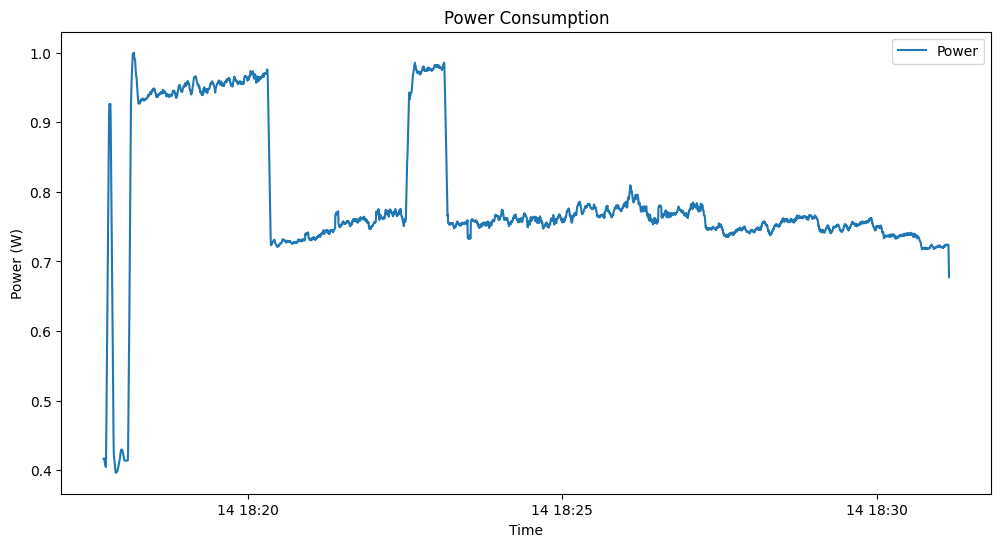

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p1.0_d2025-03-14-09-00-52.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_1.0_1_final.csv
Extracted tensor parallelism 1 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p1.0_d2025-03-14-09-00-52.csv
7822
1656


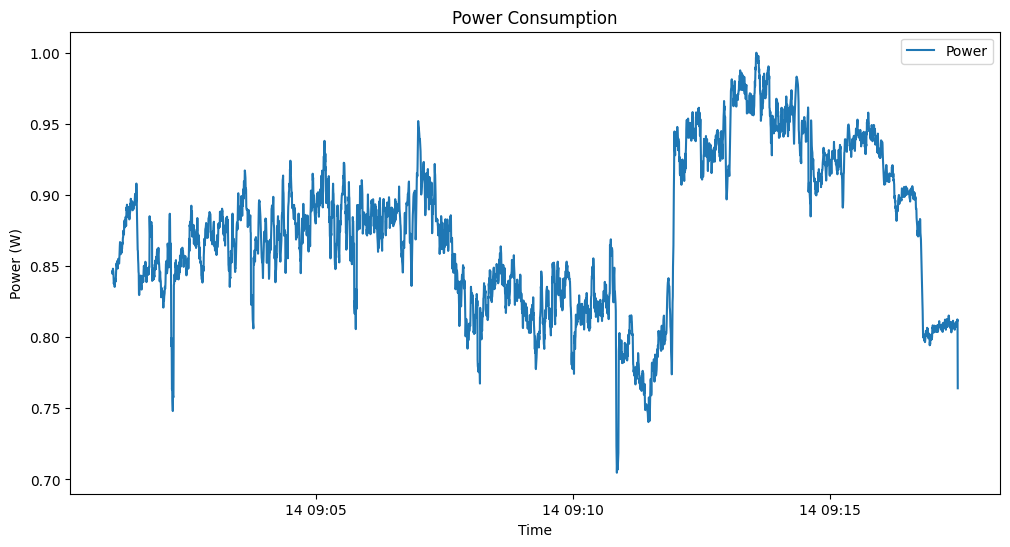

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp4_p0.25_d2025-03-14-18-31-09.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.25_4_final.csv
Extracted tensor parallelism 4 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp4_p0.25_d2025-03-14-18-31-09.csv
6598
1233


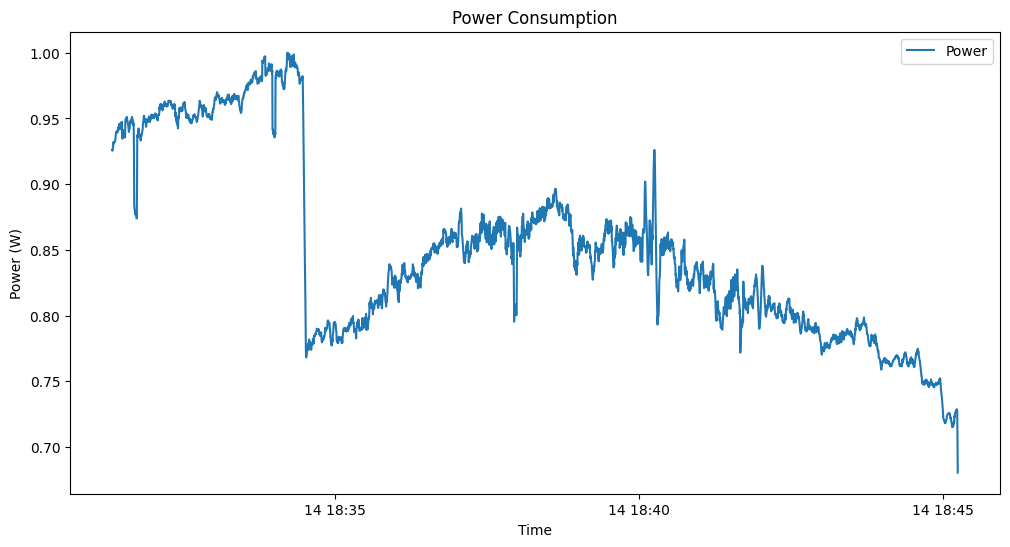

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp4_p2.0_d2025-03-14-19-15-08.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_2.0_4_final.csv
Extracted tensor parallelism 4 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp4_p2.0_d2025-03-14-19-15-08.csv
7162
1935


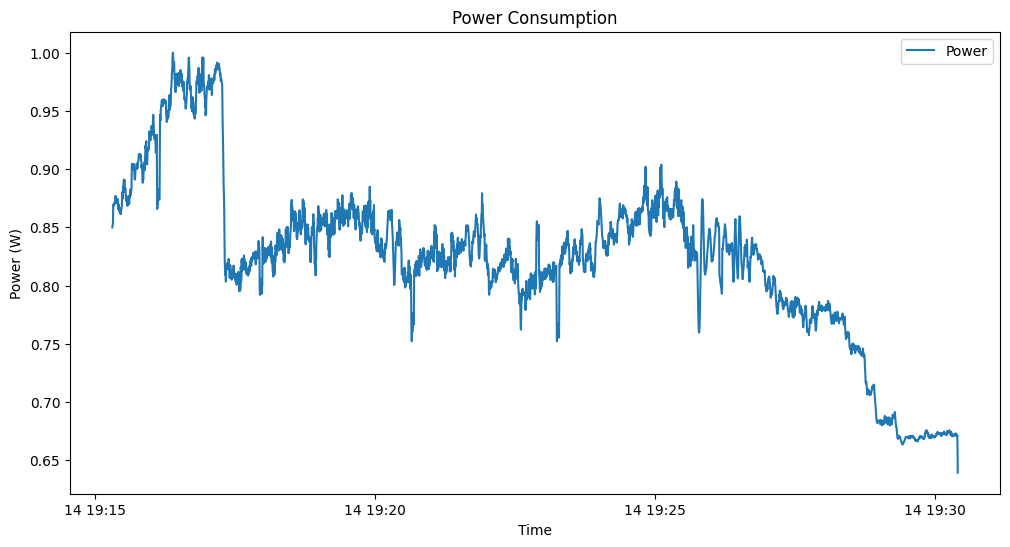

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp4_p4.0_d2025-03-14-19-30-24.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_4.0_4_final.csv
Extracted tensor parallelism 4 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp4_p4.0_d2025-03-14-19-30-24.csv
6740
2880


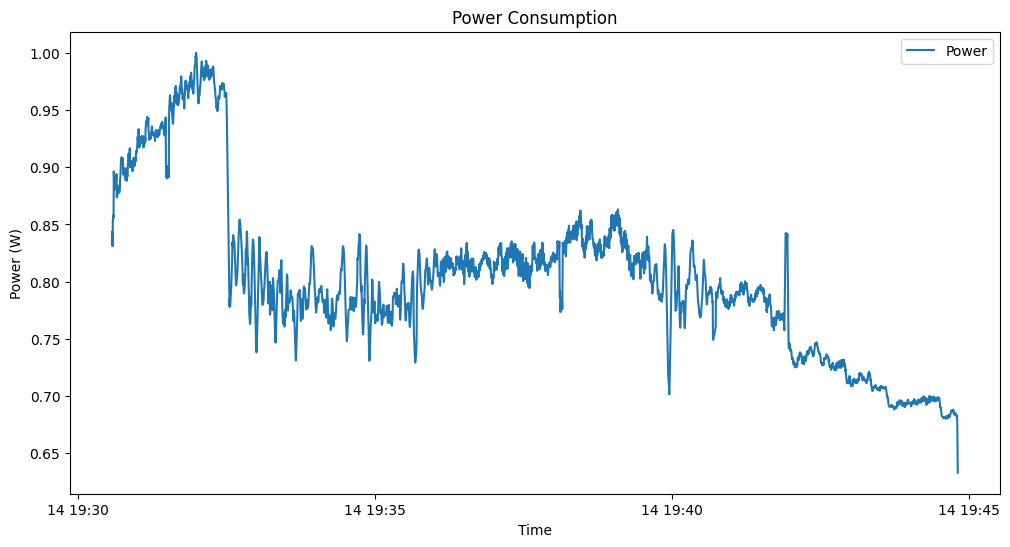

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp2_p0.5_d2025-03-14-17-14-50.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_0.5_2_final.csv
Extracted tensor parallelism 2 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp2_p0.5_d2025-03-14-17-14-50.csv
7264
2034


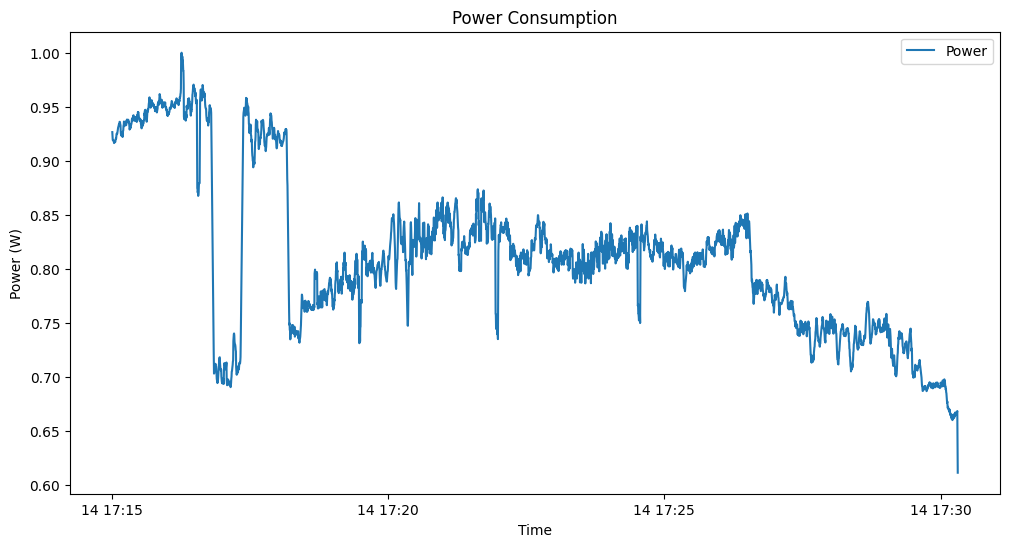

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p4.0_d2025-03-14-09-33-58.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_4.0_1_final.csv
Extracted tensor parallelism 1 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp1_p4.0_d2025-03-14-09-33-58.csv
6192
2133


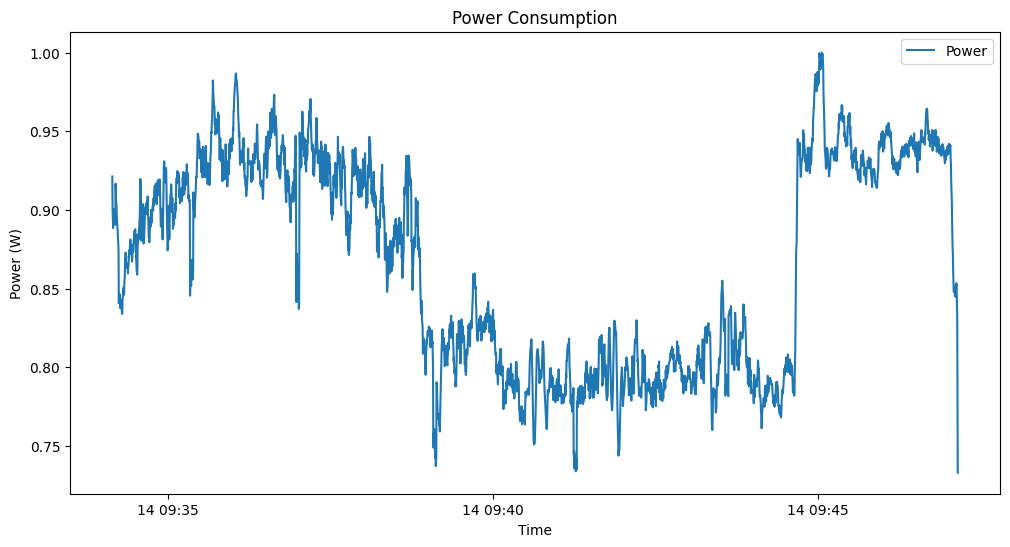

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p1.0_d2025-03-14-20-24-31.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_1.0_8_final.csv
Extracted tensor parallelism 8 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p1.0_d2025-03-14-20-24-31.csv
7464
2880


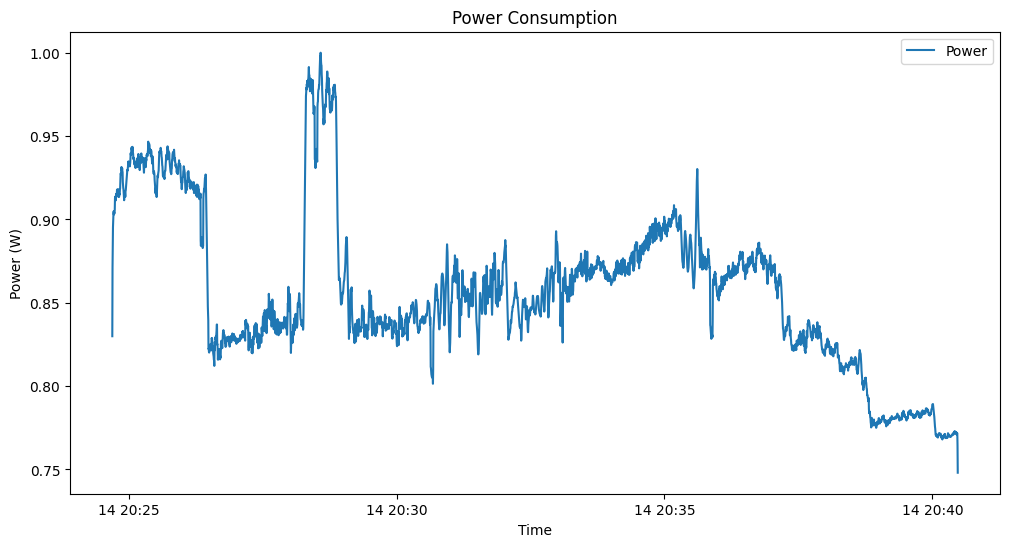

Processing ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p4.0_d2025-03-14-20-54-43.csv and ../client/deepseek-r1-distill-8b/results_deepseek-r1-distill-8b_4.0_8_final.csv
Extracted tensor parallelism 8 from ../client/deepseek-r1-distill-8b/deepseek-r1-distill-8b_tp8_p4.0_d2025-03-14-20-54-43.csv


KeyboardInterrupt: 

In [59]:
matched_pairs = discover_experiment_pairs(data_root_dir='../client/')
for power_csv, results_csv in matched_pairs:
    print(f"Processing {power_csv} and {results_csv}")
    power_df = parse_power_csv(power_csv)
    results_df = parse_results_csv(results_csv)
    # Calculate rolling mean with window size of 5
    power_df = power_df[40:-1]
    power_df['power'] = power_df['power'].rolling(window=12, min_periods=1).mean()
    power_df['power'] = power_df['power'] / power_df['power'].max()
     